In [199]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
import re
import nltk
import itertools
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk import word_tokenize
from nltk.corpus import stopwords
from gensim import corpora, models
from collections import Counter
from numpy import loadtxt
from matplotlib import pyplot
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jinu.jayan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jinu.jayan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [200]:
df = pd.read_csv("input/nyc-jobs.csv")

In [201]:
pd.set_option("display.max_columns", 28)
df.head(3)

,Job ID,Agency,Posting Type,# Of Positions,Business Title,Civil Service Title,Title Code No,Level,Job Category,Full-Time/Part-Time indicator,Salary Range From,Salary Range To,Salary Frequency,Work Location,Division/Work Unit,Job Description,Minimum Qual Requirements,Preferred Skills,Additional Information,To Apply,Hours/Shift,Work Location 1,Recruitment Contact,Residency Requirement,Posting Date,Post Until,Posting Updated,Process Date
0,87990,DEPARTMENT OF BUSINESS SERV.,Internal,1,Account Manager,CONTRACT REVIEWER (OFFICE OF L,40563,1,NaN,NaN,42405.00,65485.00,Annual,110 William St. N Y,Strategy & Analytics,Division of Economic & Financial Opportunity (...,1.\tA baccalaureate degree from an accredited ...,â€¢\tExcellent interpersonal and organizationa...,"Salary range for this position is: $42,405 - $...",NaN,NaN,NaN,NaN,New York City residency is generally required ...,2011-06-24T00:00:00.000,NaN,2011-06-24T00:00:00.000,2019-06-25T00:00:00.000
1,97899,DEPARTMENT OF BUSINESS SERV.,Internal,1,"EXECUTIVE DIRECTOR, BUSINESS DEVELOPMENT",ADMINISTRATIVE BUSINESS PROMOT,10009,M3,NaN,F,60740.00,162014.00,Annual,110 William St. N Y,Tech Talent Pipeline,The New York City Department of Small Business...,1. A baccalaureate degree from an accredited c...,NaN,NaN,"In addition to applying through this website, ...",NaN,NaN,NaN,New York City residency is generally required ...,2012-01-26T00:00:00.000,NaN,2012-01-26T00:00:00.000,2019-06-25T00:00:00.000
2,132292,NYC HOUSING AUTHORITY,External,52,Maintenance Worker - Technical Services-Heatin...,MAINTENANCE WORKER,90698,0,Maintenance & Operations,F,51907.68,54580.32,Annual,Heating Mgt-Operations,Management Services Department,"Under direct supervision, assist in the routin...",1. Three years of full-time satisfactory exper...,1. A High School Diploma or GED. 2. CDL Dri...,1. A Motor Vehicle Driverâ€™s License valid i...,"Click the ""Apply Now"" button.",NaN,NaN,NaN,NYCHA has no residency requirements.,2013-10-24T00:00:00.000,NaN,2013-12-12T00:00:00.000,2019-06-25T00:00:00.000


In [202]:
### Format the column names
df.columns = [c.replace('# Of ', 'Num ').lower().rstrip().replace(' ','_').replace('/','_') for c in df.columns.tolist() ]
df.info()
#df.loc[:10, ['Full-Time/Part-Time indicator','Salary Frequency','Work Location','Division/Work Unit','Job Description','Minimum Qual Requirements','Preferred Skills','Additional Information','To Apply']]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3113 entries, 0 to 3112
Data columns (total 28 columns):
job_id                           3113 non-null int64
agency                           3113 non-null object
posting_type                     3113 non-null object
num_positions                    3113 non-null int64
business_title                   3113 non-null object
civil_service_title              3113 non-null object
title_code_no                    3113 non-null object
level                            3113 non-null object
job_category                     3111 non-null object
full-time_part-time_indicator    2858 non-null object
salary_range_from                3113 non-null float64
salary_range_to                  3113 non-null float64
salary_frequency                 3113 non-null object
work_location                    3113 non-null object
division_work_unit               3113 non-null object
job_description                  3113 non-null object
minimum_qual_requirements    

In [203]:
df.describe()

,job_id,num_positions,salary_range_from,salary_range_to,recruitment_contact
count,3113.000000,3113.000000,3113.000000,3113.000000,0.0
mean,367173.257629,2.931577,57148.780279,83526.649060,NaN
std,45471.642602,9.948815,26979.084217,43928.529669,NaN
min,87990.000000,1.000000,0.000000,10.360000,NaN
25%,367009.000000,1.000000,47860.000000,60447.000000,NaN
50%,384345.000000,1.000000,57000.000000,81000.000000,NaN
75%,394709.000000,1.000000,71436.000000,104182.000000,NaN
max,398919.000000,150.000000,218587.000000,234402.000000,NaN


## Questions to be answered

1. What are the job categories with the most job postings.
2. What are the job categories which requires a local residency.
3. Find factors influencing mean salary.
4. Preferred skills for jobs having high salary.


## Q1 What are the job categories with the most job postings.

In [204]:
def tokenizeSeries(series):
    '''Method to replace special characters and return a single list with all the tokens in a corpus
    
    Parameters:
    argument1 (pandas series): The column data as a series

    Returns:
    a valid list
    
    '''
    print(series.shape)
    series = series.dropna()
    series = series.str.replace(' & ', ',').str.replace(',,', ',')
    catlist  = series.tolist()
    new_cat = [ x.split(',') for x in catlist]
    result = sum(new_cat, [])
    res = [x.lstrip() for x in result]
    return res

In [205]:
cat_list = tokenizeSeries(df['job_category'])
#print("--------------")
#print(cat_list)

(3113,)


In [206]:
def getjobcategoryCount(df):    
    '''Method to count the job category for the given dataframe
    
    Parameters:
    argument1 (pandas dataframe): the dataframe or any of its filtered versions

    Returns:
    Two lists, with category and and its count
    
    '''        
    cat_list = tokenizeSeries(df['job_category'])
    cat_count = Counter(cat_list)
    category = [c[0] for c in cat_count.most_common()]
    count = [c[1] for c in cat_count.most_common()]
    return category, count

In [207]:
category, count = getjobcategoryCount(df)
#print(category)

(3113,)


(3113,)


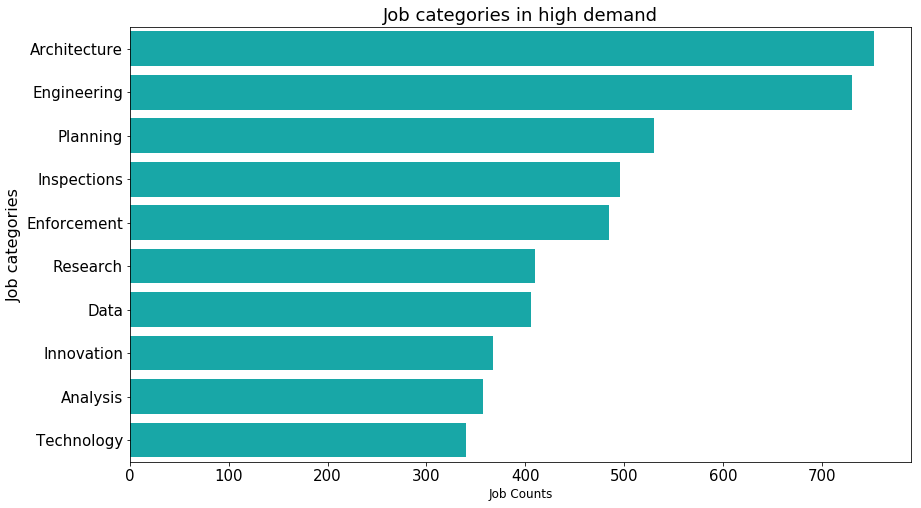

In [208]:
category, count = getjobcategoryCount(df)
f, ax = plt.subplots(figsize=(14, 8))
sns.barplot(x=count[:10], y=category[:10],  color="c")
ax.set_title('Job categories in high demand',fontsize=18)
ax.set_xlabel('Job Counts',fontsize=12)
ax.set_ylabel('Job categories',fontsize=16)
ax.tick_params(labelsize=15)
plt.savefig('Q1_a.png')
plt.show()

(3113,)


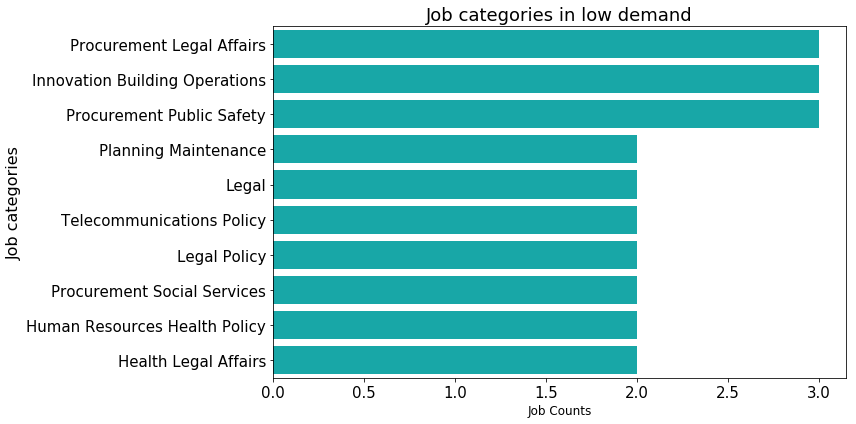

In [209]:
category, count = getjobcategoryCount(df)
f, ax = plt.subplots(figsize=(12, 6))
#sns.barplot(y=count[-30:-20], x=category[-30:-20],  color="c", orient="v")
sns.barplot(x=count[-30:-20], y=category[-30:-20],  color="c")
ax.set_title('Job categories in low demand',fontsize=18)
ax.set_xlabel('Job Counts',fontsize=12)
ax.set_ylabel('Job categories',fontsize=16)
ax.tick_params(labelsize=15)
#plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.tight_layout()
plt.savefig('Q1_b.png')
plt.show()

## Q2 Find jobs with residency conditions

In [210]:
## Customise stopwords list for the specific task to solve
custom_stpwrds = list(gensim.parsing.preprocessing.STOPWORDS)
custom_stpwrds.remove('within')
custom_stpwrds.remove('is')
custom_stpwrds.remove('no')


In [211]:
stemmer = SnowballStemmer("english")
#def lemmatize_stemming(text):
#    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    '''Method to tokenize, lemmatize ans stem the text
    
    Parameters:
    text (text string): the text data to be preprocessed

    Returns:
    A list with the cumulative tokens
    
    '''
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in custom_stpwrds and len(token) > 3:
            #result.append(lemmatize_stemming(token))
            result.append(stemmer.stem(WordNetLemmatizer().lemmatize(token, pos='v')))
    return result

def handleSpecificWords(input_str):
    '''Method to handle custom preprocessing of texts
    
    Parameters:
    input_str (text string): the text data to be preprocessed

    Returns:
    The modified version of the input_str
    
    '''
    input_str = re.sub('not require',  'not_require', input_str)
    #str = re.sub('generally require',  'generally_require', str)
    #str = re.sub('New York City', 'NewYorkCity', str)
    return input_str

In [212]:
## Call the defined methods to be applied on the data
df['residency_requirement'] = df['residency_requirement'].apply(handleSpecificWords)
processed_docs = df['residency_requirement'].map(preprocess)

In [213]:
##Create BOW corpus
dictionary = gensim.corpora.Dictionary(processed_docs)
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [215]:
##Create LDA model using tfidf of the corpus
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
#lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=2, id2word=dictionary, passes=2, workers=2)
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=2, id2word=dictionary, passes=2, workers=4)

In [216]:
## To view each data by index and to check classification
##Note current setting is for Topic == 0 == Residency required and Topic == 1== Residency not required
idx=1055
print(df['residency_requirement'][idx])
topic = sorted(lda_model_tfidf[bow_corpus[idx]],key=lambda tup: tup[1],reverse=True)[0][0]
print(topic)
if topic == 0:
    print("Class -> Residency required")
else:
    print("Class -> Residency is NOT required")

New York City residency is generally required within 90 days of appointment. However, City Employees in certain titles who have worked for the City for 2 continuous years may also be eligible to reside in Nassau, Suffolk, Putnam, Westchester, Rockland, or Orange County. To determine if the residency requirement applies to you, please discuss with the agency representative at the time of interview.
0
Class -> Residency required


In [217]:
## Showing what words constitute the topics in the topic model
lda_model_tfidf.show_topics(20)

[(0,
  '0.054*"requir" + 0.036*"time" + 0.036*"interview" + 0.036*"repres" + 0.036*"appli" + 0.035*"agenc" + 0.035*"elig" + 0.035*"appoint" + 0.035*"general" + 0.035*"continu"'),
 (1,
  '0.265*"not_requir" + 0.245*"posit" + 0.026*"citi" + 0.023*"york" + 0.021*"requir" + 0.020*"nycha" + 0.016*"nassau" + 0.016*"westchest" + 0.015*"counti" + 0.014*"certain"')]

In [218]:
## If topic == 0 we identify it as residency required (capture values as class 1)
## If topic == 1 , residency not required (capture values as class 0)
##Note: The model assigns topic numbers randomly to the colelction of words
def findTopic(corpus):
    '''Method to capture class labels given a gensim BOW corpus
    
    Parameters:
    corpus (BOW - list of int,int): the BOW representation of the corpus

    Returns:
    A list with class label for each document in the corpus
    
    '''
    
    capture_topics = []
    for idx in range(len(corpus)):
        topic = sorted(lda_model_tfidf[bow_corpus[idx]],key=lambda tup: tup[1],reverse=True)[0][0]
        if topic == 0:
        #print("Class -> Residency required")
            capture_topics.append(1)
        else:
    #print("Class -> Residency is NOT required")
            capture_topics.append(0)
    return capture_topics

In [219]:
topiclist = findTopic(bow_corpus)
df['residency_flag'] = topiclist

In [220]:
df['residency_flag'].value_counts()

1    1810
0    1303
Name: residency_flag, dtype: int64

(1810,)


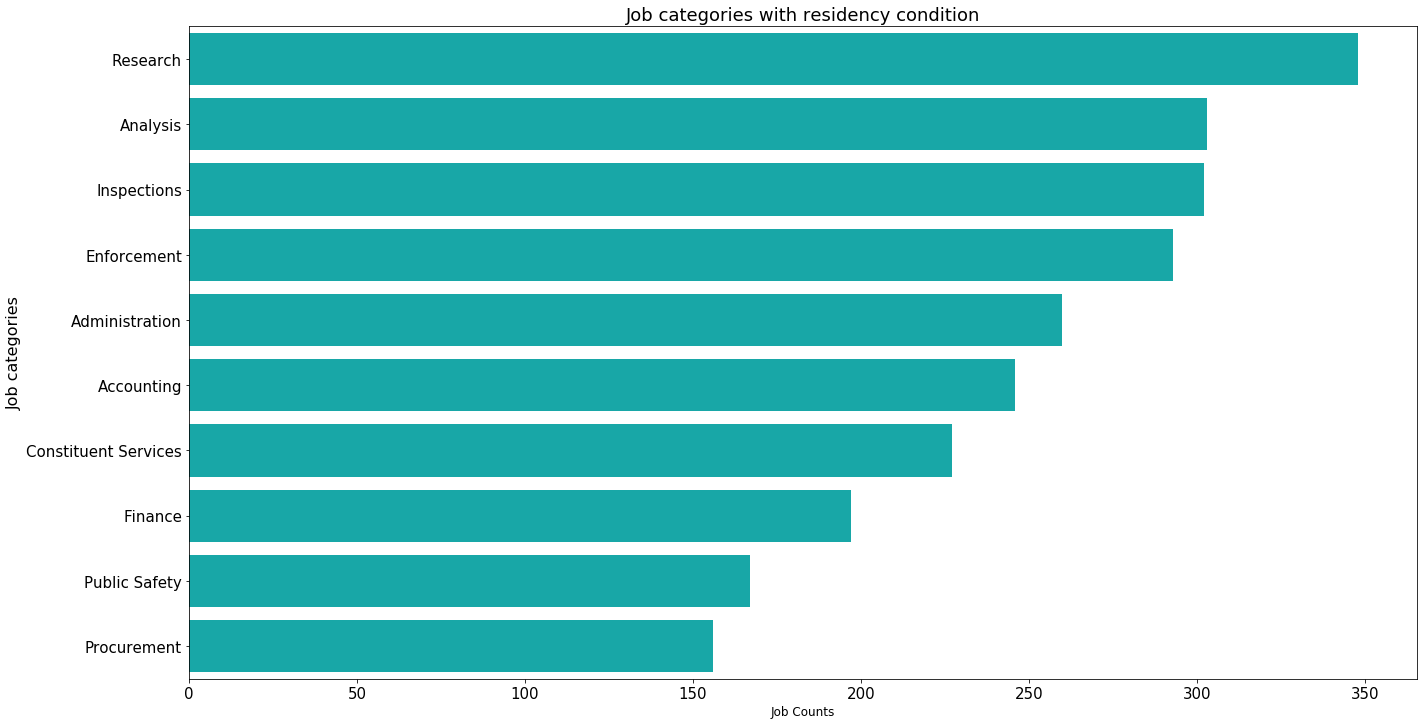

In [221]:
category, count = getjobcategoryCount(df.loc[df.residency_flag == 1])
f, ax = plt.subplots(figsize=(22, 12))
sns.barplot(x=count[:10], y=category[:10],  color="c")
ax.set_title('Job categories with residency condition',fontsize=18)
ax.set_xlabel('Job Counts',fontsize=12)
ax.set_ylabel('Job categories',fontsize=16)
ax.tick_params(labelsize=15)
plt.savefig('Q2_a.png')
plt.show()

(1303,)


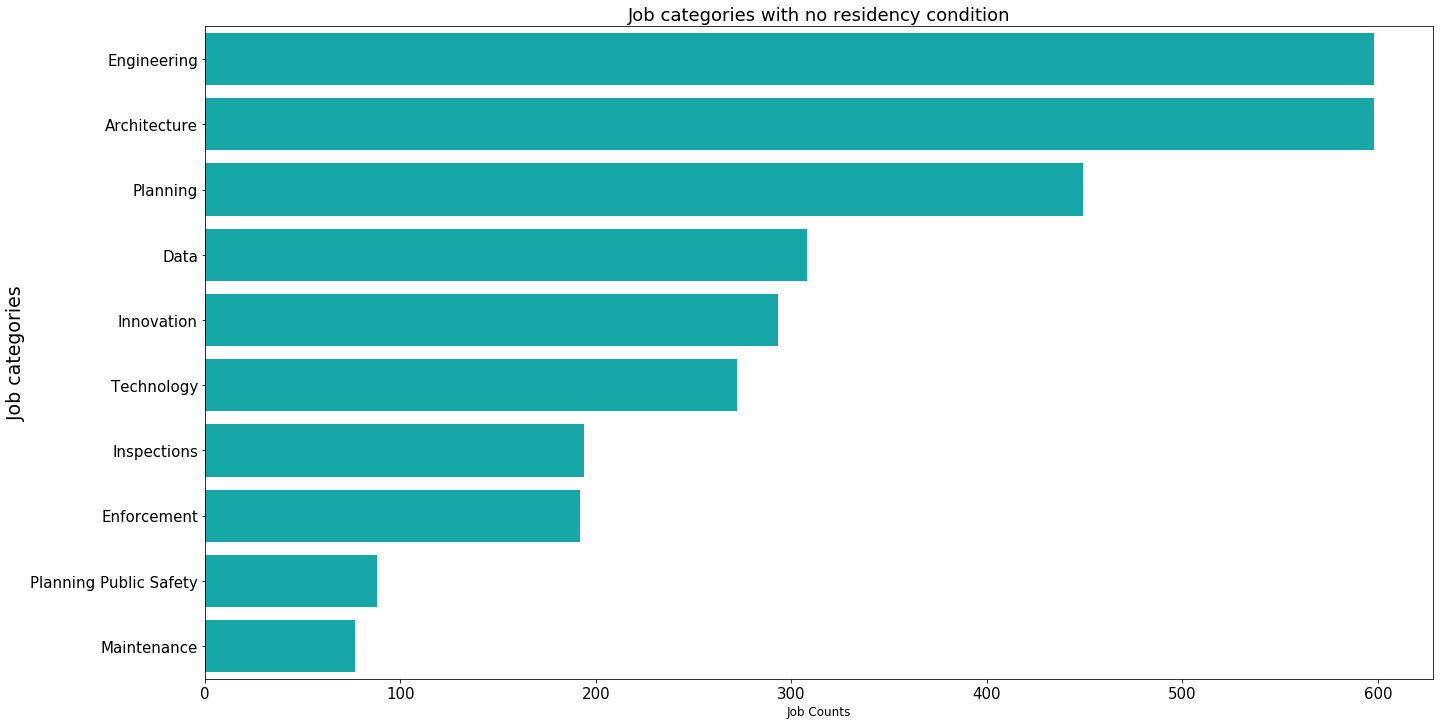

In [222]:
category, count = getjobcategoryCount(df.loc[df.residency_flag == 0])
f, ax = plt.subplots(figsize=(22, 12))
sns.barplot(x=count[:10], y=category[:10],  color="c")
ax.set_title('Job categories with no residency condition',fontsize=18)
ax.set_xlabel('Job Counts',fontsize=12)
ax.set_ylabel('Job categories',fontsize=19)
ax.tick_params(labelsize=15)
plt.savefig('Q2_b.png')
plt.show()

## Q3 Find the features impacting mean salary

To analyze the features that influence job mean salary we can model the mean salary as a decision output of an ensemble model with some of the features available in the data set and some engineered.

In [223]:
df['mean_salary'] = (df['salary_range_from'] +  df['salary_range_to'])/2

In [224]:
df.loc[:5, ['salary_range_from', 'salary_range_to','salary_frequency','mean_salary']]

,salary_range_from,salary_range_to,salary_frequency,mean_salary
0,42405.00,65485.00,Annual,53945.0
1,60740.00,162014.00,Annual,111377.0
2,51907.68,54580.32,Annual,53244.0
3,51907.68,54580.32,Annual,53244.0
4,35.00,35.00,Hourly,35.0
5,35.00,35.00,Hourly,35.0


In [225]:
df = df.dropna(subset = ['full-time_part-time_indicator'])
X = df.loc[:,['agency','posting_type','num_positions','civil_service_title','level','full-time_part-time_indicator','salary_frequency','residency_flag']]
y = df.loc[X.salary_frequency == 'Annual'].mean_salary


In [226]:
X = X.loc[X.salary_frequency == 'Annual']
X.shape
x_cols =X.columns

In [227]:
x_cols

Index(['agency', 'posting_type', 'num_positions', 'civil_service_title',
       'level', 'full-time_part-time_indicator', 'salary_frequency',
       'residency_flag'],
      dtype='object')

In [228]:
X.head()

,agency,posting_type,num_positions,civil_service_title,level,full-time_part-time_indicator,salary_frequency,residency_flag
1,DEPARTMENT OF BUSINESS SERV.,Internal,1,ADMINISTRATIVE BUSINESS PROMOT,M3,F,Annual,1
2,NYC HOUSING AUTHORITY,External,52,MAINTENANCE WORKER,0,F,Annual,0
3,NYC HOUSING AUTHORITY,Internal,52,MAINTENANCE WORKER,0,F,Annual,0
6,DEPT OF HEALTH/MENTAL HYGIENE,Internal,1,PROCUREMENT ANALYST,3,F,Annual,1
7,DEPT OF ENVIRONMENT PROTECTION,Internal,1,ASSOCIATE CHEMIST,2,F,Annual,1


In [229]:
##Apply label encoding to categorical features
X=X.apply(preprocessing.LabelEncoder().fit_transform)
X.head(3)

,agency,posting_type,num_positions,civil_service_title,level,full-time_part-time_indicator,salary_frequency,residency_flag
1,10,1,0,13,11,0,0,1
2,43,0,23,204,0,0,0,0
3,43,1,23,204,0,0,0,0


In [230]:
##Divide data set into train and test groups
X_train,X_test,Y_train,Y_test=train_test_split(X,y,test_size = 0.2, random_state = 42)
X_train.shape

(2072, 8)

In [231]:
##Fit the data to a Regression model to find a relation ship between independent feaures and the mean salary
rf = RandomForestRegressor(n_estimators = 500, random_state = 42)
rf.fit(X_train, Y_train.ravel());
# Use the forest's predict method on the test data
predictions = rf.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - Y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'Dollars')

Mean Absolute Error: 4861.56 Dollars


In [232]:
# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(x_cols, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: level                Importance: 0.56
Variable: civil_service_title  Importance: 0.22
Variable: residency_flag       Importance: 0.11
Variable: agency               Importance: 0.09
Variable: num_positions        Importance: 0.02
Variable: posting_type         Importance: 0.0
Variable: full-time_part-time_indicator Importance: 0.0
Variable: salary_frequency     Importance: 0.0


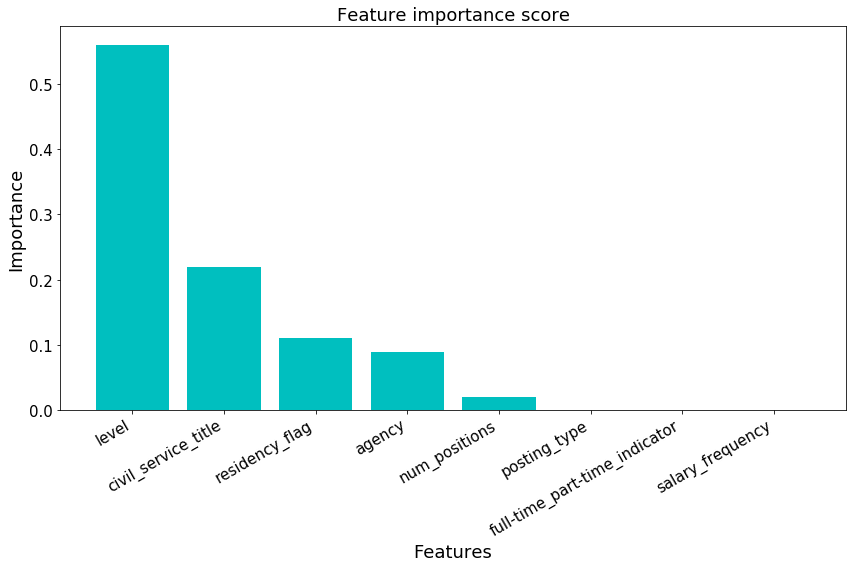

In [233]:
features = [f[0] for f in feature_importances]
values = [f[1] for f in feature_importances]
fig,ax = plt.subplots(1,1,figsize=(12,8))

ax.bar(features[:20], values[:20],color='c')

ax.set_xlabel('Features',fontsize=18)
ax.set_ylabel('Importance',fontsize=18)

ax.set_title('Feature importance score',fontsize=18)
ax.tick_params(labelsize=15)

#axes[1].set_title('Mode cost analysis')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.tight_layout()
plt.savefig('Q3_model.png')
plt.show()

## Further analyze on residency flag and agency features

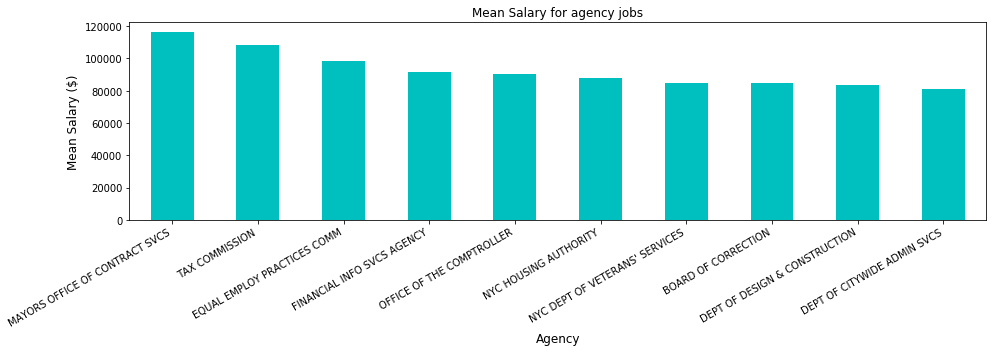

In [234]:
ax = df.groupby('agency').mean_salary.mean().sort_values(ascending=False)[:10].plot(kind = 'bar',figsize=(14,5), color = 'c')
ax.set_title('Mean Salary for agency jobs')
ax.set_ylabel('Mean Salary ($)',fontsize=12)
ax.set_xlabel('Agency',fontsize=12)
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.tight_layout()
plt.savefig('Q3_b_agency.png')
plt.show()

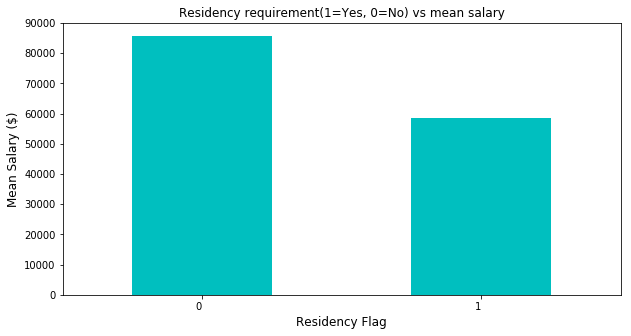

In [235]:
ax = df.groupby('residency_flag').mean_salary.mean().sort_values(ascending=False).plot(kind = 'bar',figsize=(10,5), color = 'c')
ax.set_title('Residency requirement(1=Yes, 0=No) vs mean salary')
ax.set_ylabel('Mean Salary ($)',fontsize=12)
ax.set_xlabel('Residency Flag',fontsize=12)
plt.setp(ax.get_xticklabels(), rotation=0, horizontalalignment='right')
plt.savefig('Q3_c.png')
plt.show()

## Q4 Preferred skills for high and low mean salary

In [247]:
### Function to evaluate word count for each word in the corpus
def wordcount(cleaned_text):
    '''Method to create a dictionary of word count for each word in the corpus
    
    Parameters:
    corpus (pandas series): the raw text corpus 

    Returns:
    A sorted dictionary of words in the corpus and the frequency
    
    '''
    custom_stpwrds = list(gensim.parsing.preprocessing.STOPWORDS)
    custwrds = ['excellent','knowledge','skill','abil','knowledg','skil','ability']
    custom_stpwrds.extend(custwrds)
    processed_skill_text = cleaned_text.map(preprocess)
    text_list = list(processed_skill_text)
    dictionary_skills = gensim.corpora.Dictionary(text_list)
    merged = list(itertools.chain.from_iterable(text_list))
    bow_corpus = dictionary_skills.doc2bow(merged)
    word_count = []
    count = 0
    for wrd,idx in dictionary_skills.token2id.items():
        #print(f"The word and idx is {wrd}--{idx}")
    #print(bow_dict[idx] )
        count = count + 1
        if wrd not in custom_stpwrds:
            word_count.append(tuple([wrd,bow_corpus[idx][1]]))
        #print(f"The bowcorpus data is {bow_corpus[idx]}")
        
        #if count == 10:
            #break
    return dict(sorted(word_count, key = lambda x : x[1], reverse = True))

In [237]:
def plot_wordcloud(data, file,freq=False,):
    '''Method to plot the word cloud of the processed text data or the word frequency
    
    Parameters:
    data (python data structure) : the processed text corpus or the word frequency
    file (string) : The filename for the file to be saved locally
    freq (boolean) : If a frequency type data(word and its count) is passed
    
    
    '''
    if freq:
        #wordcloud = WordCloud(background_color='white',max_words=100,width=512, height=512).fit_words(data)
        #wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").fit_words(data)
        wordcloud = WordCloud(width=1600, height=800,max_words=100).fit_words(data)
        
    else:
        wordcloud = WordCloud(background_color='white',
                     width=1024, height=720).generate(data)
    
    plt.figure( figsize=(16,8), facecolor='k')
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.savefig(file)
    plt.show()

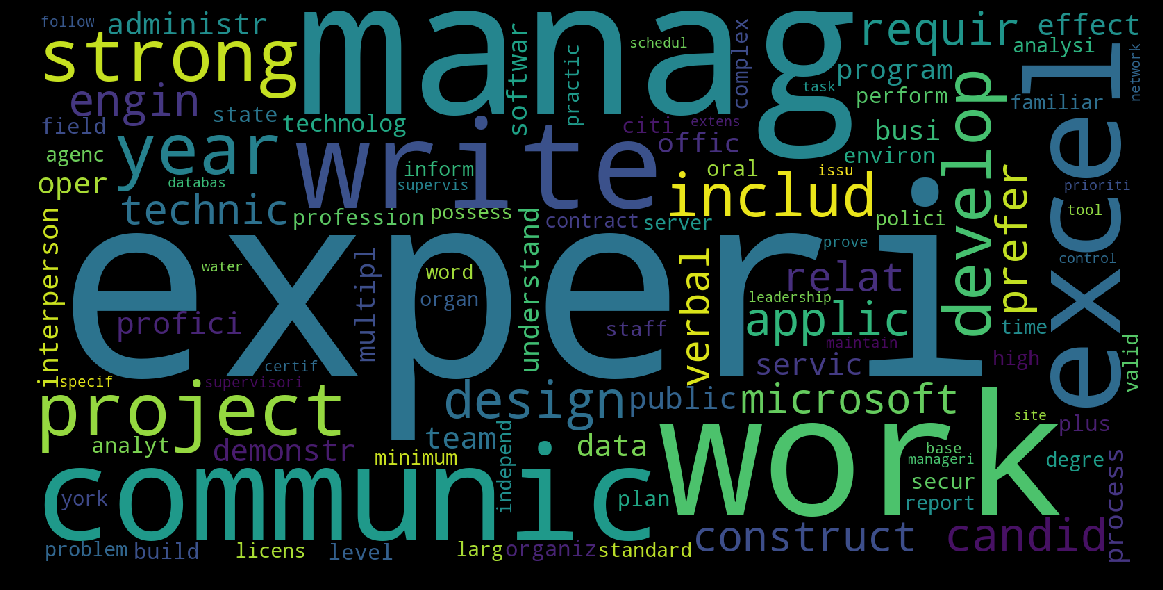

In [248]:
df = df.dropna(subset=['preferred_skills'])
df['preferred_skills'] = df.preferred_skills.astype(str)
wordcount_high_sal = wordcount(df.loc[(df.mean_salary >= df.mean_salary.quantile(0.75))].preferred_skills.replace('[^a-zA-Z ]',' ', regex = True).str.lower())
plot_wordcloud(wordcount_high_sal,'Q4_high.png',freq=True)

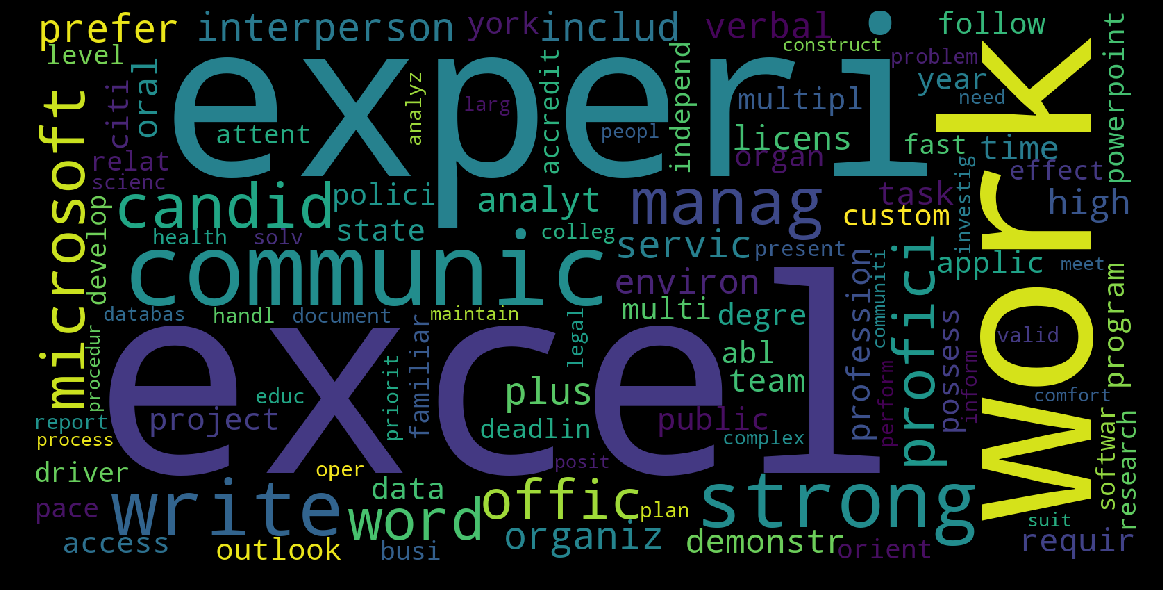

In [249]:
wordcount_low_sal = wordcount(df.loc[(df.mean_salary <= df.mean_salary.quantile(0.25))].preferred_skills.replace('[^a-zA-Z ]',' ', regex = True).str.lower())
plot_wordcloud(wordcount_low_sal,'Q4_low.png', freq=True)

## Inference:

We can see that the high salary job category demands good managerial experience, demonstrated leadership. Most of the relatively low salary jobs focus on specific skills, good knowledge of Microsoft power point,word. Good written and verbal communication being an important skill in both the types of categories.